In [4]:
import os
import pandas as pd
import networkx as nx
from node2vec import Node2Vec

# Directory containing subject files
subject_files_dir = 'C:/Users/thaplood2/Documents/Subjects/132017/'  # Update this path

# List of all subject file paths
subject_files = [f for f in os.listdir(subject_files_dir) if f.endswith('aparc35.xlsx')]

# Define the regions and corresponding sheet names
regions = {
    'inter': ('sigConn_inter', 'inter_fc'),
    'LH': ('sigConn_LH', 'LH_fc'),
    'RH': ('sigConn_RH', 'RH_fc')
}

# Function to save all outputs to one Excel file per subject and region in a folder
def save_subject_results(subject_code, region, embeddings_df, properties_df, edges_df, summary_df):
    # Create folder based on subject code if it doesn't already exist
    output_folder = os.path.join(subject_files_dir, f'{subject_code}_node2vec')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define the output file path
    output_filename = os.path.join(output_folder, f'{subject_code}_{region}_analysis_results.xlsx')

    # Save the different DataFrames to the Excel file with multiple sheets
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        embeddings_df.to_excel(writer, sheet_name='Node Embeddings')
        properties_df.to_excel(writer, sheet_name='Graph Properties')
        edges_df.to_excel(writer, sheet_name='Edges and Weights')
        summary_df.to_excel(writer, sheet_name='Summary Statistics')

    print(f"All outputs have been saved to '{output_filename}' for {subject_code} - {region.upper()}.")

# Process each subject file
for subject_file in subject_files:
    subject_code = os.path.splitext(subject_file)[0]  # Extract subject code from filename
    file_path = os.path.join(subject_files_dir, subject_file)
    
    # Process each region (inter, LH, RH)
    for region, (sig_conn_sheet, fc_sheet) in regions.items():
        # Load the respective sheets for ROI pairs and correlations
        roi_edges = pd.read_excel(file_path, sheet_name=sig_conn_sheet)
        correlations = pd.read_excel(file_path, sheet_name=fc_sheet)
        
        # Create graphs for each time point
        num_timepoints = correlations.shape[1]  # Assuming columns are time points
        all_embeddings = []  # To store embeddings for each time point
        all_properties = []  # To store properties for each time point
        
        for t in range(num_timepoints):
            G = nx.Graph()
            for i, row in roi_edges.iterrows():
                roi1 = row['ROI1']
                roi2 = row['ROI2']
                weight = correlations.iloc[i, t]  # Correlation value at time point t
                G.add_edge(roi1, roi2, weight=weight)
            
            # Step 4: Apply Node2Vec to each graph and store embeddings
            node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=1, workers=8)
            model = node2vec.fit(window=10, min_count=1, batch_words=4)
            embeddings = {node: model.wv[node] for node in G.nodes()}
            all_embeddings.append(embeddings)  # Store embeddings for the current time point

            # Step 2: Calculate Graph Properties for this time point
            degree_centrality = nx.degree_centrality(G)
            betweenness_centrality = nx.betweenness_centrality(G)

            # Store the properties for each node at this time point
            properties_df = pd.DataFrame({
                'Node': degree_centrality.keys(),
                'Degree Centrality': degree_centrality.values(),
                'Betweenness Centrality': betweenness_centrality.values(),
                'Time Point': [t] * len(degree_centrality)  # Add time point for each node
            })
            all_properties.append(properties_df)  # Store the properties for this time point

        # Flatten embeddings across all time points into a DataFrame
        embeddings_flat = []
        for t, embeddings in enumerate(all_embeddings):
            for node, emb in embeddings.items():
                embeddings_flat.append([node, t] + list(emb))
        embeddings_df = pd.DataFrame(embeddings_flat, columns=['Node', 'Time Point'] + [f'Embedding_{i+1}' for i in range(64)])

        # Flatten properties across all time points into a single DataFrame
        properties_df_flat = pd.concat(all_properties, ignore_index=True)

        # Step 3: Extract Edges and Weights
        edges_data = []
        for t in range(num_timepoints):
            for i, row in roi_edges.iterrows():
                roi1 = row['ROI1']
                roi2 = row['ROI2']
                weight = correlations.iloc[i, t]
                edges_data.append([roi1, roi2, weight, t])
        edges_df = pd.DataFrame(edges_data, columns=['Source', 'Target', 'Weight', 'Time Point'])

        # Step 4: Summary Statistics (can still be done for the averaged graph or global)
        summary_stats = {
            'Number of Nodes': G.number_of_nodes(),
            'Number of Edges': G.number_of_edges(),
            'Density': nx.density(G),
            'Time Points': num_timepoints
        }
        summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Value'])

        # Save the results after processing this region for the current subject
        save_subject_results(subject_code, region, embeddings_df, properties_df_flat, edges_df, summary_df)


Computing transition probabilities: 100%|████████████████████████████████████████████| 31/31 [00:00<00:00, 8501.04it/s]
C:\Users\thaplood2\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Computing transition probabilities: 100%|██████████████████████████████████████████████████████| 31/31 [00:00<?, ?it/s]


All outputs have been saved to 'C:/Users/thaplood2/Documents/Subjects/132017/132017_jackknife_sigConn_aparc35_node2vec\132017_jackknife_sigConn_aparc35_inter_analysis_results.xlsx' for 132017_jackknife_sigConn_aparc35 - INTER.


Computing transition probabilities: 100%|██████████████████████████████████████████████████████| 21/21 [00:00<?, ?it/s]


All outputs have been saved to 'C:/Users/thaplood2/Documents/Subjects/132017/132017_jackknife_sigConn_aparc35_node2vec\132017_jackknife_sigConn_aparc35_LH_analysis_results.xlsx' for 132017_jackknife_sigConn_aparc35 - LH.


Computing transition probabilities: 100%|██████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]
C:\Users\thaplood2\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Computing transition probabilities: 100%|██████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]


All outputs have been saved to 'C:/Users/thaplood2/Documents/Subjects/132017/132017_jackknife_sigConn_aparc35_node2vec\132017_jackknife_sigConn_aparc35_RH_analysis_results.xlsx' for 132017_jackknife_sigConn_aparc35 - RH.


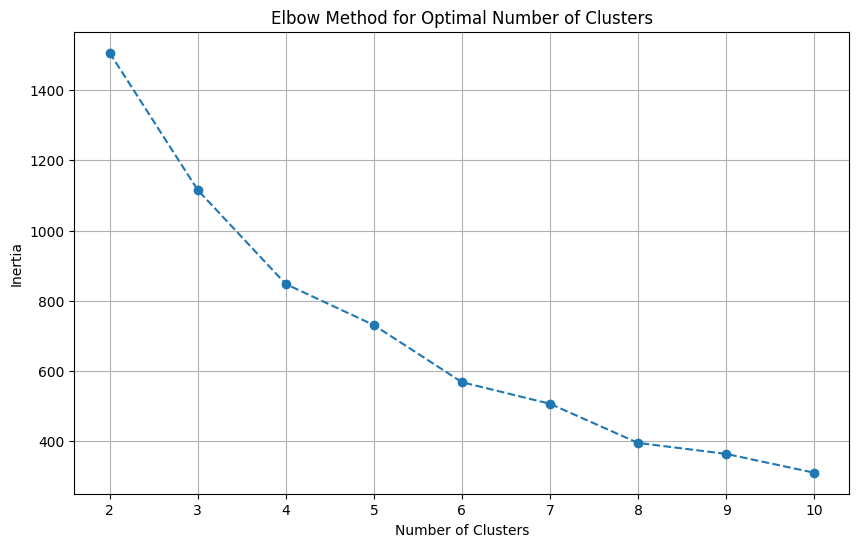

Optimal number of clusters determined automatically: 2
Saved dendrogram for 100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx - Node Embeddings
Clustering results saved for 100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx - Node Embeddings


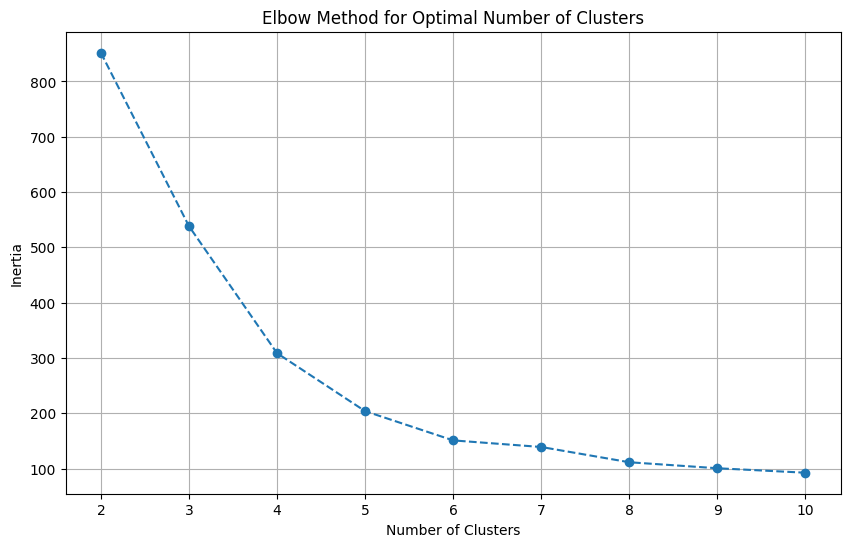

Optimal number of clusters determined automatically: 2
Saved dendrogram for 100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx - Node Embeddings
Clustering results saved for 100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx - Node Embeddings


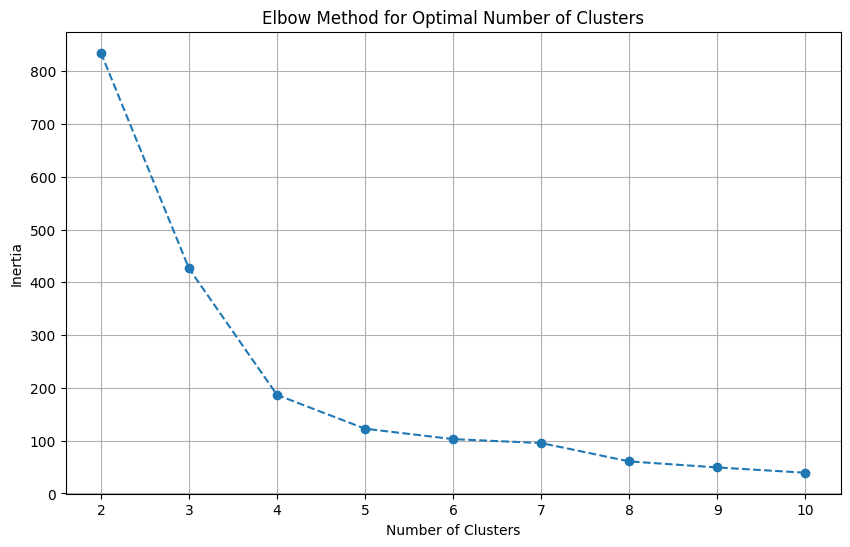

Optimal number of clusters determined automatically: 2
Saved dendrogram for 100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx - Node Embeddings
Clustering results saved for 100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx - Node Embeddings


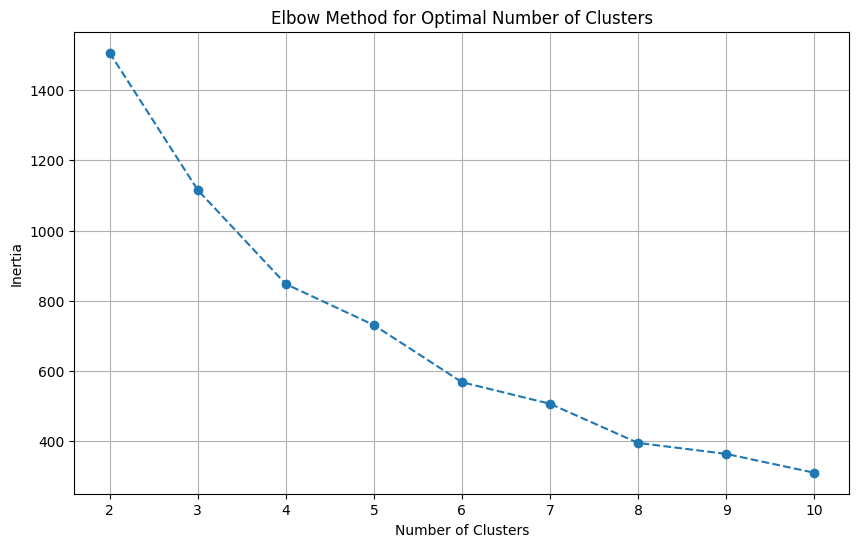

Optimal number of clusters determined automatically: 2
Saved dendrogram for clustered_100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx - Node Embeddings
Clustering results saved for clustered_100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx - Node Embeddings


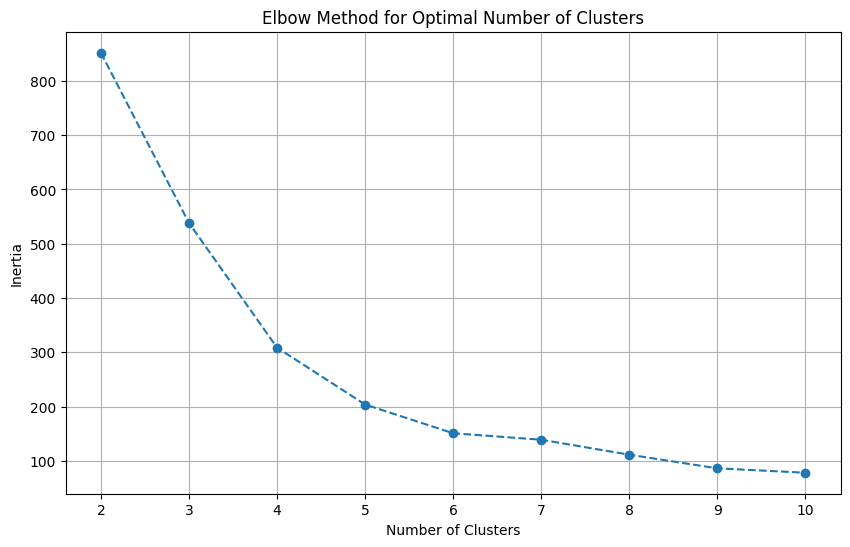

Optimal number of clusters determined automatically: 2
Saved dendrogram for clustered_100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx - Node Embeddings
Clustering results saved for clustered_100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx - Node Embeddings


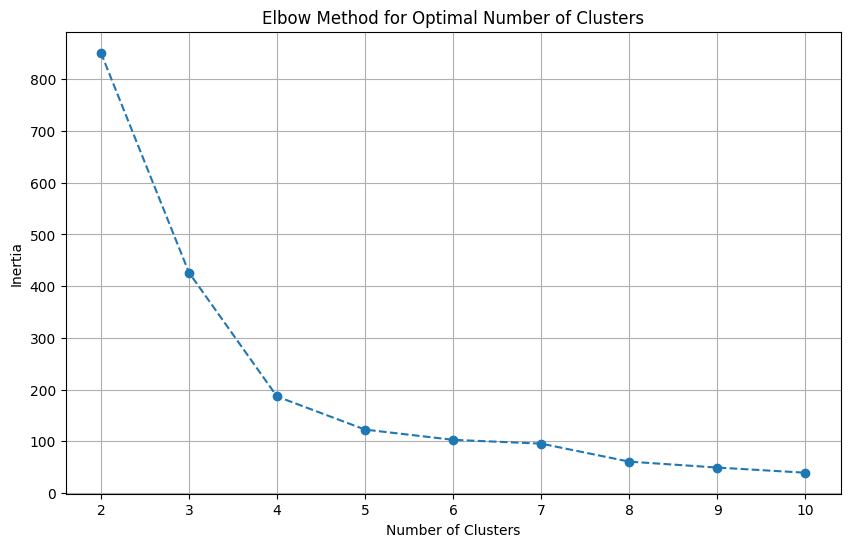

Optimal number of clusters determined automatically: 2
Saved dendrogram for clustered_100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx - Node Embeddings
Clustering results saved for clustered_100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx - Node Embeddings


In [12]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Set the paths for the input folder and output folder
input_folder = 'C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec'
output_folder = 'C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to determine the optimal number of clusters using the elbow method
def find_optimal_clusters(X):
    inertia_values = []
    range_n_clusters = range(2, 11)  # Adjust the range as needed

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, inertia_values, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

    # Automatically determine the optimal number of clusters
    differences = [inertia_values[i] - inertia_values[i + 1] for i in range(len(inertia_values) - 1)]
    optimal_n_clusters = differences.index(max(differences)) + 2  # +2 because index starts at 0
    print(f'Optimal number of clusters determined automatically: {optimal_n_clusters}')

    return optimal_n_clusters

# Function to perform clustering and save dendrogram and results
def perform_clustering(file_path, sheet_name='Node Embeddings'):
    # Load node embeddings from the specified sheet
    df_node_embeddings = pd.read_excel(file_path, sheet_name=sheet_name)

    # Preprocess data: Standardize the features
    X = df_node_embeddings.iloc[:, 1:].values  # Skip the node label column
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine optimal number of clusters using the elbow method
    optimal_n_clusters = find_optimal_clusters(X_scaled)

    # Perform linkage for dendrogram
    linked = linkage(X_scaled, method='ward')

    # Plot and save the dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linked, labels=df_node_embeddings.iloc[:, 0].values, distance_sort='descending')
    plt.title(f'Dendrogram for {os.path.basename(file_path)} - {sheet_name}')
    plt.xlabel('Nodes')
    plt.ylabel('Distance')
    dendrogram_path = os.path.join(output_folder, f'dendrogram_{os.path.basename(file_path).replace(".xlsx", "")}_{sheet_name}.png')
    plt.savefig(dendrogram_path)
    plt.close()
    print(f'Saved dendrogram for {os.path.basename(file_path)} - {sheet_name}')

    # Apply Agglomerative Clustering with the chosen number of clusters
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters,linkage='ward')
    labels = agg_clustering.fit_predict(X_scaled)

    # Add cluster labels to DataFrame
    df_node_embeddings['Cluster'] = labels

    # Save the clustered data to a new Excel file
    output_file = os.path.join(output_folder, f'clustered_{os.path.basename(file_path)}')
    df_node_embeddings.to_excel(output_file, sheet_name=sheet_name, index=False)
    print(f'Clustering results saved for {os.path.basename(file_path)} - {sheet_name}')

# Loop through all Excel files in the input folder and process each
for file_name in os.listdir(input_folder):
    if file_name.endswith('.xlsx'):  # Ensure only Excel files are processed
        file_path = os.path.join(input_folder, file_name)
        
        # Process the Node Embeddings sheet for each Excel file
        perform_clustering(file_path, sheet_name='Node Embeddings')




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Define the directory containing the Excel files
input_directory = 'C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec'  # Update with your folder path

# List all Excel files in the directory
excel_files = [f for f in os.listdir(input_directory) if f.endswith('.xlsx')]

# Initialize a list to hold the evaluation scores
scores_list = []

for excel_file in excel_files:
    # Construct the full file path
    file_path = os.path.join(input_directory, excel_file)
    
    # Load the Node Embeddings sheet (assuming rows are node IDs and columns are features)
    node_embeddings = pd.read_excel(file_path, sheet_name='Node Embeddings', index_col=0)

    # Extract node IDs and node features
    node_ids = node_embeddings.index.values  # The node IDs are the row indices
    node_features = node_embeddings.values   # The rest are the features

    # Load the Edges and Weights sheet
    edges_weights = pd.read_excel(file_path, sheet_name='Edges and Weights')
    edges = edges_weights[['Source', 'Target']].values
    weights = edges_weights['Weight'].values

    # Convert the node names to lowercase to avoid case sensitivity issues
    edges[:, 0] = [node.lower() for node in edges[:, 0]]
    edges[:, 1] = [node.lower() for node in edges[:, 1]]
    node_ids = np.array([node.lower() for node in node_ids])

    # Create an adjacency matrix
    n_nodes = len(node_ids)
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Populate the adjacency matrix with better error handling
    for i, (node1, node2) in enumerate(edges):
        try:
            index1 = np.where(node_ids == node1)[0][0]
            index2 = np.where(node_ids == node2)[0][0]
        except IndexError:
            print(f"Node {node1} or {node2} not found in Node Embeddings. Skipping this edge.")
            continue
        
        # Add the weights to the adjacency matrix
        adj_matrix[index1, index2] = weights[i]
        adj_matrix[index2, index1] = weights[i]  # Assuming undirected graph

    # Normalize node features
    scaler = StandardScaler()
    node_features_scaled = scaler.fit_transform(node_features)

    # Find the optimal number of clusters using the elbow method
    wcss = []  # Within-cluster sum of squares
    for n_clusters in range(2, 11):  # Test cluster numbers from 2 to 10
        try:
            spectral_clustering = SpectralClustering(
                n_clusters=n_clusters, 
                affinity='precomputed', 
                assign_labels='kmeans'
            )
            clusters = spectral_clustering.fit_predict(adj_matrix)
            
            # Calculate WCSS
            cluster_centers = np.array([node_features_scaled[clusters == k].mean(axis=0) for k in range(n_clusters)])
            wcss.append(sum(np.sum((node_features_scaled[clusters == k] - cluster_centers[k]) ** 2) for k in range(n_clusters)))
        except Exception as e:
            print(f"Error with {n_clusters} clusters: {e}")
            continue

    # Plot the elbow method result
    plt.figure()
    plt.plot(range(2, len(wcss) + 2), wcss, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title(f"Elbow Method for {excel_file}")
    plt.savefig(os.path.join(input_directory, f'elbow_method_{os.path.splitext(excel_file)[0]}.png'))
    plt.close()

    # Find the "elbow" point, where the rate of decrease sharply declines
    # Typically the "elbow" is where the WCSS decrease slows down significantly
    optimal_n_clusters = np.argmin(np.diff(np.diff(wcss))) + 2  # +2 to align with the cluster range starting from 2

    # Perform spectral clustering with the optimal number of clusters
    spectral_clustering = SpectralClustering(
        n_clusters=optimal_n_clusters, 
        affinity='precomputed', 
        assign_labels='kmeans'
    )
    clusters = spectral_clustering.fit_predict(adj_matrix)

    # Add cluster labels to the node embeddings dataframe
    node_embeddings['Cluster'] = clusters

    # Evaluate clustering
    calinski_harabasz = calinski_harabasz_score(node_features_scaled, clusters)
    davies_bouldin = davies_bouldin_score(node_features_scaled, clusters)

    # Append scores to the scores list
    scores_list.append({
        'Subject': excel_file,
        'Optimal Clusters': optimal_n_clusters,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Davies-Bouldin Index': davies_bouldin
    })

    # Print the evaluation scores
    print(f'Optimal number of clusters for {excel_file}: {optimal_n_clusters}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

    # Save the result to a new Excel file in the same directory
    output_file = os.path.join(input_directory, f'spectral_clustering_result{os.path.splitext(excel_file)[0]}.xlsx')
    node_embeddings.to_excel(output_file, index=False)

    print(f'Clustering completed for {excel_file}. Results saved to {output_file}')

    # ---- Visualization ----
    # Reduce dimensionality for visualization using PCA
    pca = PCA(n_components=2)
    node_features_2d = pca.fit_transform(node_features_scaled)

    # Plot the 2D PCA projection with clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(node_features_2d[:, 0], node_features_2d[:, 1], c=clusters, cmap='viridis', s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f"Spectral Clustering - PCA Visualization ({excel_file})")
    plt.savefig(os.path.join(input_directory, f'pca_visualization_{os.path.splitext(excel_file)[0]}.png'))  # Save the plot
    plt.close()  # Close the plot to avoid displaying it in Jupyter notebooks

# After processing all subjects, save the scores to a new Excel file
scores_df = pd.DataFrame(scores_list)
scores_output_file = os.path.join(input_directory, 'clustering_scores.xlsx')
scores_df.to_excel(scores_output_file, index=False)

print(f'All clustering scores saved to {scores_output_file}.')




C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifol

Optimal number of clusters for 100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx: 6
Calinski-Harabasz Index: 14.6026
Davies-Bouldin Index: 0.9078
Clustering completed for 100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx. Results saved to C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec\spectral_clustering_result_new100206_jackknife_sigConn_aparc35_inter_analysis_results.xlsx
Optimal number of clusters for 100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx: 7
Calinski-Harabasz Index: 15.9133
Davies-Bouldin Index: 0.6455
Clustering completed for 100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx. Results saved to C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec\spectral_clustering_result_new100206_jackknife_sigConn_aparc35_LH_analysis_results.xlsx


C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\thaplood2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifol

Optimal number of clusters for 100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx: 7
Calinski-Harabasz Index: 24.6385
Davies-Bouldin Index: 0.5051
Clustering completed for 100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx. Results saved to C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec\spectral_clustering_result_new100206_jackknife_sigConn_aparc35_RH_analysis_results.xlsx
All clustering scores saved to C:/Users/thaplood2/Documents/100206_jackknife_sigConn_aparc35_node2vec\clustering_scores_new.xlsx.


Clustering scores file not found in C:/Users/thaplood2/Documents/Custom Office Templates
Clustering scores file not found in C:/Users/thaplood2/Documents/My Music
Clustering scores file not found in C:/Users/thaplood2/Documents/My Pictures
Clustering scores file not found in C:/Users/thaplood2/Documents/My Videos


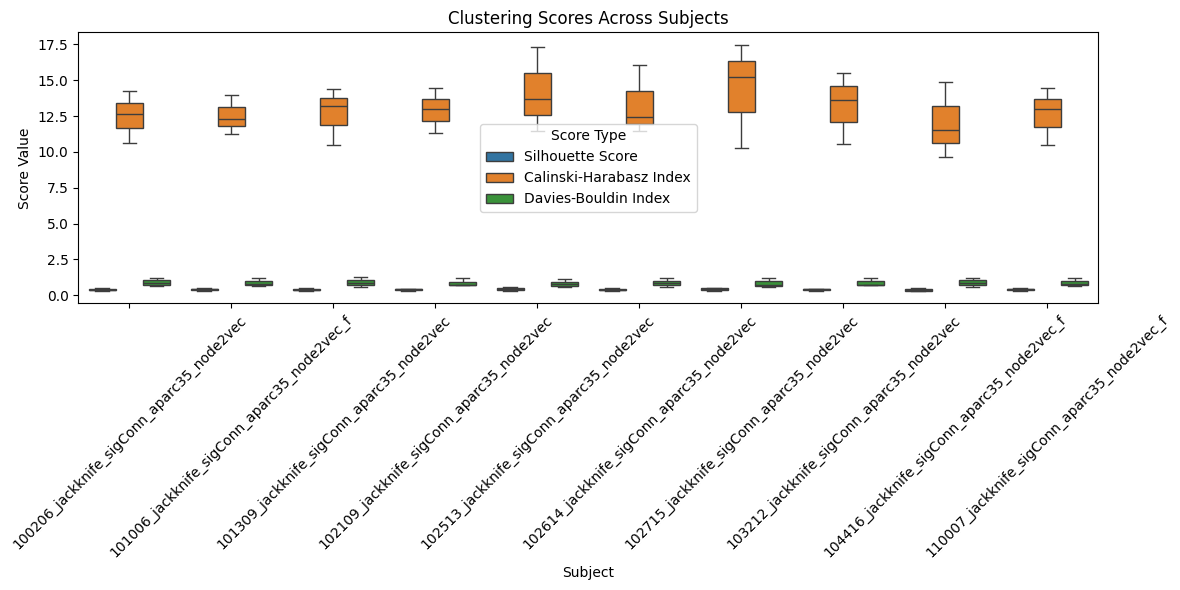

In [40]:
!pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the main directory containing all subject folders
main_directory = 'C:/Users/thaplood2/Documents/'  # Update with your folder path

# Initialize a list to store all scores
all_scores = []

# Loop through each subject folder in the main directory
for subject_folder in os.listdir(main_directory):
    subject_path = os.path.join(main_directory, subject_folder)
    
    # Check if it's a directory
    if os.path.isdir(subject_path):
        # Construct the path to the clustering scores file
        scores_file_path = os.path.join(subject_path, 'clustering_scores.xlsx')
        
        # Check if the clustering scores file exists
        if os.path.isfile(scores_file_path):
            # Load the clustering scores
            scores_df = pd.read_excel(scores_file_path)
            
            # Add a new column for the subject name
            scores_df['Subject'] = subject_folder
            
            # Append the scores DataFrame to the list
            all_scores.append(scores_df)
        else:
            print(f"Clustering scores file not found in {subject_path}")

# Concatenate all scores DataFrames into a single DataFrame
combined_scores_df = pd.concat(all_scores, ignore_index=True)

# Melt the DataFrame for easier plotting
melted_scores_df = combined_scores_df.melt(id_vars='Subject', 
                                             value_vars=['Silhouette Score', 
                                                         'Calinski-Harabasz Index', 
                                                         'Davies-Bouldin Index'], 
                                             var_name='Score Type', 
                                             value_name='Score Value')

# Set the figure size
plt.figure(figsize=(12, 6))

# Create box plots for each score type
sns.boxplot(x='Subject', y='Score Value', hue='Score Type', data=melted_scores_df)
plt.xticks(rotation=45)
plt.title('Clustering Scores Across Subjects')
plt.xlabel('Subject')
plt.ylabel('Score Value')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
import os

# Define the main directory containing all subject folders
main_directory = 'C:/Users/thaplood2/Documents'  # Update with your folder path

# Initialize a list to store all scores
all_scores = []

# Loop through each subject folder in the main directory
for subject_folder in os.listdir(main_directory):
    subject_path = os.path.join(main_directory, subject_folder)
    
    # Check if it's a directory
    if os.path.isdir(subject_path):
        # Construct the path to the clustering scores file
        scores_file_path = os.path.join(subject_path, 'clustering_scores.xlsx')
        
        # Check if the clustering scores file exists
        if os.path.isfile(scores_file_path):
            # Load the clustering scores
            scores_df = pd.read_excel(scores_file_path)
            
            # Add a new column for the subject name
            scores_df['Subject'] = subject_folder
            
            # Append the scores DataFrame to the list
            all_scores.append(scores_df)
        else:
            print(f"Clustering scores file not found in {subject_path}")

# Concatenate all scores DataFrames into a single DataFrame
combined_scores_df = pd.concat(all_scores, ignore_index=True)

# Calculate summary statistics for each score type
summary_stats = combined_scores_df.groupby('Subject').agg(
    Mean=('Silhouette Score', 'mean'),
    Median=('Silhouette Score', 'median'),
    StdDev=('Silhouette Score', 'std'),
    Mean_Calinski=('Calinski-Harabasz Index', 'mean'),
    Median_Calinski=('Calinski-Harabasz Index', 'median'),
    StdDev_Calinski=('Calinski-Harabasz Index', 'std'),
    Mean_Davies=('Davies-Bouldin Index', 'mean'),
    Median_Davies=('Davies-Bouldin Index', 'median'),
    StdDev_Davies=('Davies-Bouldin Index', 'std'),
).reset_index()

# Display the summary statistics
print(summary_stats)

# Optionally, save the summary statistics to an Excel file
output_file = os.path.join(main_directory, 'summary_statistics.xlsx')
summary_stats.to_excel(output_file, index=False)
print(f'Summary statistics saved to {output_file}')


Clustering scores file not found in C:/Users/thaplood2/Documents\Custom Office Templates
Clustering scores file not found in C:/Users/thaplood2/Documents\My Music
Clustering scores file not found in C:/Users/thaplood2/Documents\My Pictures
Clustering scores file not found in C:/Users/thaplood2/Documents\My Videos
                                       Subject      Mean    Median    StdDev  \
0    100206_jackknife_sigConn_aparc35_node2vec  0.393682  0.382021  0.099838   
1  101006_jackknife_sigConn_aparc35_node2vec_f  0.400427  0.412153  0.086203   
2    101309_jackknife_sigConn_aparc35_node2vec  0.399340  0.390430  0.102001   
3    102109_jackknife_sigConn_aparc35_node2vec  0.401524  0.426750  0.066090   
4    102513_jackknife_sigConn_aparc35_node2vec  0.425751  0.412507  0.116179   
5    102614_jackknife_sigConn_aparc35_node2vec  0.411310  0.385012  0.104719   
6    102715_jackknife_sigConn_aparc35_node2vec  0.419722  0.446804  0.109735   
7    103212_jackknife_sigConn_aparc35_node2ve